<a href="https://colab.research.google.com/github/nerumur/Valeria_ML/blob/main/hw_3_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/content/Corona.csv', encoding='latin-1')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


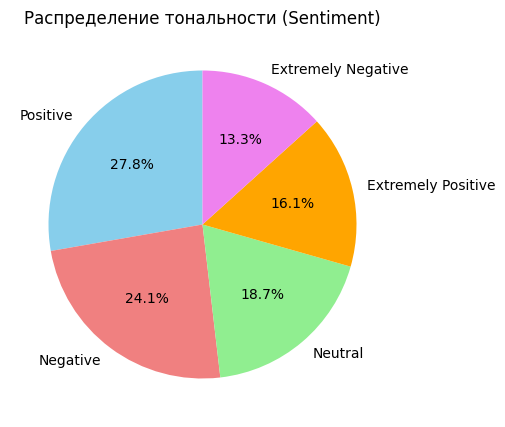

In [4]:
vis = df['Sentiment'].value_counts()   # подсчет значений
fig = plt.figure(figsize=(5, 5))
plt.pie(vis, labels=vis.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'violet'])
plt.title('Распределение тональности (Sentiment)')
plt.show()

**Препроцессинг датасета.**

In [5]:
df = df[['OriginalTweet','Sentiment']].dropna()   # нам нужны только эти 2 колонки
#df.head()

In [6]:
stop_words = stopwords.words('english')

def data_cleaner(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)   # url
    tweet = re.sub(r'<.*?>',' ', tweet)      # html
    tweet = re.sub(r'\d+',' ', tweet)        # цифры
    tweet = re.sub(r'#\w+',' ', tweet)       # хештеги
    tweet = re.sub(r'@\w+',' ', tweet)       # @
    tweet = tweet.split()                    # стоп-слова
    tweet = " ".join([word for word in tweet if not word in stop_words])
    return tweet

df['OriginalTweet'] = df['OriginalTweet'].apply(data_cleaner)
df.head(10)

,OriginalTweet,Sentiment
0,,Neutral
1,advice Talk neighbours family exchange phone n...,Positive
2,Coronavirus Australia: Woolworths give elderly...,Positive
3,"My food stock one empty... PLEASE, panic, THER...",Positive
4,"Me, ready go supermarket outbreak. Not I'm par...",Extremely Negative
5,As news regionÂs first confirmed COVID- case ...,Positive
6,Cashier grocery store sharing insights To prov...,Positive
7,Was supermarket today. Didn't buy toilet paper.,Neutral
8,Due COVID- retail store classroom Atlanta open...,Positive
9,"For corona prevention,we stop buy things cash ...",Negative


In [7]:
# токенизация + векторизация + выравниваем длину

tokenizer = Tokenizer()    # создаем токенизатор

tokenizer.fit_on_texts(df["OriginalTweet"])

sequences = tokenizer.texts_to_sequences(df["OriginalTweet"])

pad_seq = pad_sequences(sequences, maxlen=150, padding='post')  # выравниваем длину

In [8]:
# векторизуем колонку Sentiment

df = pd.get_dummies(df, columns=['Sentiment'])  # one-hot encoding
df.head()

,OriginalTweet,Sentiment_Extremely Negative,Sentiment_Extremely Positive,Sentiment_Negative,Sentiment_Neutral,Sentiment_Positive
0,,False,False,False,True,False
1,advice Talk neighbours family exchange phone n...,False,False,False,False,True
2,Coronavirus Australia: Woolworths give elderly...,False,False,False,False,True
3,"My food stock one empty... PLEASE, panic, THER...",False,False,False,False,True
4,"Me, ready go supermarket outbreak. Not I'm par...",True,False,False,False,False


**Обучаем.**

In [9]:
X = pad_seq   #данные
y = df[['Sentiment_Extremely Negative', 'Sentiment_Extremely Positive', 'Sentiment_Negative', 'Sentiment_Neutral', 'Sentiment_Positive']] #метки

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

In [11]:
# выстраиваем модель
model = models.Sequential([
    layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=16),     # слой, переводит целые числа в плотные вектора
    layers.Conv1D(32, 3, activation='relu'),             # первый одномерный сверточный слой, кол-во фильтров = 32, ширина окна для фильтров = 3
    layers.MaxPooling1D(),                               # уменьшаем набор данных, берем только самое важное
    layers.Conv1D(64, 3, activation='relu'),             # второй одномерный сверточный слой
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),                 # обобщение инф-ии, выдает 64 обобщенных признака
    layers.Dense(5, activation='softmax')                # выходной слой, у нас многоклассовая классификация и подходит софтмакс
])

# собираем модель
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4072 - loss: 1.3477 - val_accuracy: 0.7049 - val_loss: 0.7930
Epoch 2/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7670 - loss: 0.6434 - val_accuracy: 0.7481 - val_loss: 0.7058
Epoch 3/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8551 - loss: 0.4331 - val_accuracy: 0.7465 - val_loss: 0.7192
Epoch 4/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9011 - loss: 0.3152 - val_accuracy: 0.7352 - val_loss: 0.8287
Epoch 5/5
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9313 - loss: 0.2165 - val_accuracy: 0.7329 - val_loss: 0.9615


In [12]:
# оцениваем
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

258/258 - 1s - 2ms/step - accuracy: 0.7329 - loss: 0.9615
Test accuracy: 0.7329


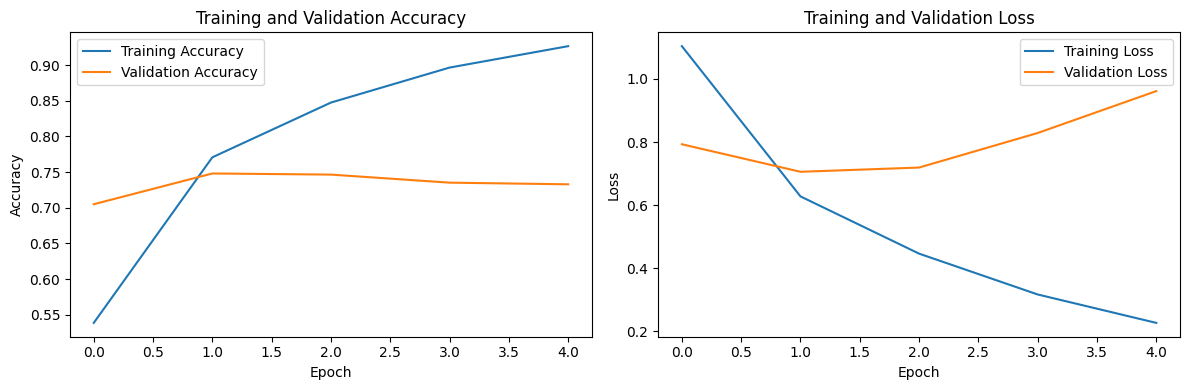

In [13]:
# Отрисовка графика прогресса обучения
plt.figure(figsize=(12, 4))

# Отрисовка точности модели
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Отрисовка значений функции потерь
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report

y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']))
# вроде все неплохо, для модели с предсказанием 5 классов

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
                    precision    recall  f1-score   support

Extremely Negative       0.78      0.64      0.70      1056
          Negative       0.80      0.69      0.74      1330
           Neutral       0.66      0.70      0.68      2006
          Positive       0.89      0.79      0.84      1553
Extremely Positive       0.66      0.80      0.73      2287

          accuracy                           0.73      8232
         macro avg       0.76      0.72      0.74      8232
      weighted avg       0.74      0.73      0.73      8232



In [15]:
# попробуем что-то поменять

model_2 = models.Sequential([
    layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=16),
    layers.Conv1D(32, 6, activation='relu'), # пробуем увеличить окошко, может помочь модели улавливать более длинные фразы и зависимости между словами
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 6, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),            # добавляем Dropout с вероятностью отключения 50%
    layers.Dense(5, activation='softmax')
])

model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)     # EarlyStopping - останавливает обучение, если метрика не улучшается

history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stop])  # увеличиваем кол-во эпох

Epoch 1/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3638 - loss: 1.4263 - val_accuracy: 0.6871 - val_loss: 0.8411
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7345 - loss: 0.7378 - val_accuracy: 0.7539 - val_loss: 0.7010
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8280 - loss: 0.5296 - val_accuracy: 0.7623 - val_loss: 0.7333
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8748 - loss: 0.3949 - val_accuracy: 0.7494 - val_loss: 0.7785
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8984 - loss: 0.3263 - val_accuracy: 0.7547 - val_loss: 0.8665


In [16]:
# оцениваем
test_loss, test_acc = model_2.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc:.4f}")

258/258 - 1s - 2ms/step - accuracy: 0.7539 - loss: 0.7010
Test accuracy: 0.7539


In [17]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model_2.predict(X_test), axis=1)

print(classification_report(y_test_labels, y_pred_labels, target_names=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']))

# результат немного улучшился!
# думаю, результат был бы лучше, если бы классов было меньше (например, 3)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                    precision    recall  f1-score   support

Extremely Negative       0.83      0.59      0.69      1056
          Negative       0.79      0.78      0.79      1330
           Neutral       0.67      0.73      0.70      2006
          Positive       0.86      0.82      0.84      1553
Extremely Positive       0.72      0.79      0.75      2287

          accuracy                           0.75      8232
         macro avg       0.77      0.74      0.75      8232
      weighted avg       0.76      0.75      0.75      8232



In [18]:
model.save("corona_CNN_model.keras")